In [1]:
#PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import collections
import random
import re

# Matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

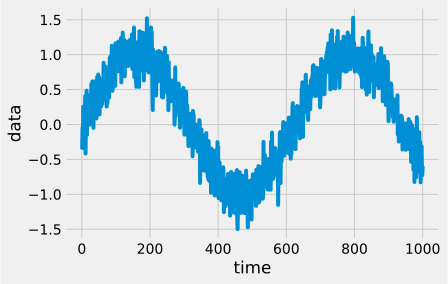

In [2]:
class Data(Dataset):
    def __init__(self, T=1000, tau=4) -> None:
        self.T = torch.arange(1, T+1).long()
        self.x = torch.sin(0.01 * self.T) + torch.randn(T)*0.2
        self.tau = tau
        #features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        #self.features = torch.stack(features, 1)
        #self.labels = self.x[self.tau:].reshape((-1,1)) 

    def __len__(self):
        return (len(self.x))

    def __getitem__(self, idx):
        return self.x[idx], self.T[idx]

data = Data()

plt.figure(figsize=(6,4))
plt.plot(data.T, data.x)
plt.xlabel('time')
plt.ylabel('data')

data_dl = DataLoader(data, batch_size=64)


In [19]:
[data.x[i : data.T-data.tau+i] for i in range(data.tau)]

TypeError: only integer tensors of a single element can be converted to an index

In [25]:
data.T-data.tau

tensor([ -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
         11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 1

In [3]:
class Vocab:  # @save
    """Vocabulary for text."""

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)

        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}



    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']


class TimeMachine(Dataset):
    def __init__(self, num_steps, num_train=10000, num_val=5000) -> None:
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def _download(self):
        with open('data/timemachine.txt') as f:
            return f.read()

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)

    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None:
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]



In [9]:
data = TimeMachine(num_steps=10)
data_dl = DataLoader(data, batch_size=2)

raw_text = data._download()
text = data._preprocess(raw_text)
tokens = data._tokenize(text)

for X, Y in data_dl:
    print('X:', X, '\nY:', Y)
    break

X: tensor([[21,  9,  6,  0, 21, 10, 14,  6,  0, 14],
        [ 9,  6,  0, 21, 10, 14,  6,  0, 14,  2]]) 
Y: tensor([[ 9,  6,  0, 21, 10, 14,  6,  0, 14,  2],
        [ 6,  0, 21, 10, 14,  6,  0, 14,  2,  4]])


In [11]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [12]:
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [13]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

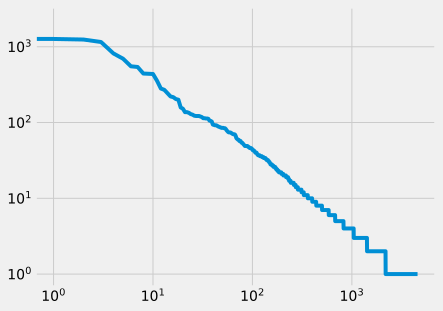

In [14]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.loglog(freqs)

In [15]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [16]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

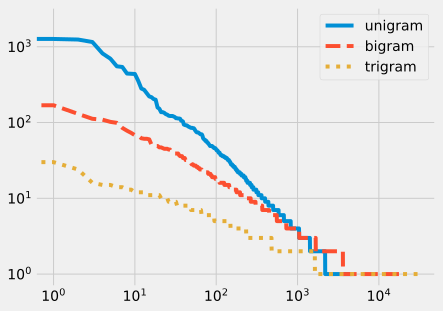

In [101]:
freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plt.loglog(freqs, 'C0-', label='unigram')
plt.loglog(bigram_freqs, 'C1--', label='bigram')
plt.loglog(trigram_freqs, 'C2:', label='trigram')
plt.legend()

## RNN From Sctrach

In [100]:
class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01) -> None:
        super().__init__()

        self.num_hiddens = num_hiddens
        self.sigma = sigma
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens)*sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens))
        else:
            state = state
        outputs = []
        for X in inputs:
            state = torch.tanh(X @ self.W_xh + state @ self.W_hh + self.b_h)
            outputs.append(state)

        return outputs, state



In [38]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

print (X.shape)
print (len(outputs), state.shape)

torch.Size([100, 2, 16])
100 torch.Size([2, 32])


In [39]:
def check_len(a, n):  #@save
    assert len(a) == n, f'list\'s len {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [108]:
class RNNLMScratch(nn.Module):
    def __init__(self, rnn, vocab_size, lr=0.01) -> None:
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = nn.CrossEntropyLoss(self(*batch[:-1]), batch[-1])
        # plt.plot...
        return l

    def validation_step(self, batch):
        l = nn.CrossEntropyLoss(self(*batch[:-1]), batch[-1])
        # plt.plot...
        return l

    def one_hot(self, X):
        return torch.nn.functional.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [H @ self.W_hq +  self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)


    


In [109]:
model = RNNLMScratch(rnn, num_inputs)

outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))


In [53]:
outputs.shape

torch.Size([2, 100, 16])

In [70]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)

In [71]:
print (data[0])

for batch in data_dl:
    x, y = batch
    print (x)
    print (y)
    break

(tensor([21,  9,  6,  0, 21, 10, 14,  6,  0, 14,  2,  4,  9, 10, 15,  6,  0,  3,
        26,  0,  9,  0,  8,  0, 24,  6, 13, 13, 20,  0, 10,  0]), tensor([ 9,  6,  0, 21, 10, 14,  6,  0, 14,  2,  4,  9, 10, 15,  6,  0,  3, 26,
         0,  9,  0,  8,  0, 24,  6, 13, 13, 20,  0, 10,  0, 21]))
tensor([[ 6,  0, 16,  ...,  0, 24,  9],
        [ 0, 20, 17,  ..., 19, 15,  6],
        [ 0, 21, 16,  ..., 12,  0, 24],
        ...,
        [19,  2, 10,  ...,  7,  0, 21],
        [15, 26,  0,  ...,  7,  6,  2],
        [ 6,  5,  0,  ..., 16,  0, 22]])
tensor([[ 0, 16, 15,  ..., 24,  9,  2],
        [20, 17, 10,  ..., 15,  6,  5],
        [21, 16, 16,  ...,  0, 24, 10],
        ...,
        [ 2, 10,  5,  ...,  0, 21,  9],
        [26,  0, 19,  ...,  6,  2, 19],
        [ 5,  0,  4,  ...,  0, 22, 21]])


In [83]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)

In [84]:
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)

In [85]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)

rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
x, y = next(iter(data_dl))
print (x.shape)
rnn(x)

torch.Size([1024, 32])
torch.Size([32])
torch.Size([28, 32])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 28x32)

In [133]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

print (X.shape)
#print (len(outputs), state.shape)
outputs[0].shape

torch.Size([100, 2, 16])


torch.Size([2, 32])

In [80]:
X.shape, x.shape

(torch.Size([100, 2, 16]), torch.Size([1024, 32]))

In [188]:
class RNNScratch(nn.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01) -> None:
        super().__init__()

        self.num_hiddens = num_hiddens
        self.sigma = sigma
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens)*sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens))
        else:
            state = state
        outputs = []
        for X in inputs:
            state = torch.tanh(X @ self.W_xh + state @ self.W_hh + self.b_h)
            outputs.append(state)

        return outputs, state

class RNNLMScratch(nn.Module):
    def __init__(self, rnn, vocab_size, lr=0.01) -> None:
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = nn.functional.cross_entropy(self(*batch[:-1]), batch[-1])
        # plt.plot...
        return l

    def validation_step(self, batch):
        l = nn.CrossEntropyLoss(self(*batch[:-1]), batch[-1])
        # plt.plot...
        return l

    def one_hot(self, X):
        return torch.nn.functional.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [H @ self.W_hq +  self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

In [137]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)

rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
x, y = next(iter(data_dl))
print (x.shape)
model(x).shape

torch.Size([1024, 32])


torch.Size([1024, 32, 28])

In [185]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

print (outputs.shape)

AttributeError: 'RNN' object has no attribute 'sigma'

In [176]:
for batch in data_dl:
    x, y = batch

    logits = model(x)

    #print (torch.arange(32))
    print (y[0][0])
    #print (logits[0][0][y[0][0]])
    xx = [logits[i][torch.arange(32),y[i]] for i in range(len(y))]
    yy = torch.tensor(xx)
    print (len(xx))
    #print (y.shape)

    loss = nn.functional.cross_entropy(logits[:], y[:])
    break

tensor(10)


ValueError: only one element tensors can be converted to Python scalars

In [189]:
class RNN(nn.Module):  #@save
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

class RNNLM(RNNLMScratch):  #@save
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [179]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)

In [190]:
data = TimeMachine(num_steps=32)
data_dl = DataLoader(data, batch_size=1024, shuffle=True)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)    

In [226]:
for batch in data_dl:
    #model.training_step(batch)
    x, y = batch

    logits = model(x)

    print (logits.shape)
    yy = nn.functional.one_hot(y,28)

    '''
    loss = 0.0
    for i in range(1024):
        for j in range(32):
            loss += logits[i][j][y[j]].mean()

        break
    '''

    logits = logits.reshape((-1, 28))

    y = y.reshape((-1,))
    loss = nn.functional.cross_entropy(logits, y, reduction='mean')

    loss.backward()

    #nn.functional.cross_entropy(logits, yy)
    break

torch.Size([1024, 32, 28])
